# Modelling and Computational Engineering Project 2


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

##  Exercise 1

### Part 1

In [21]:
df = pd.read_csv('/Users/lars/Documents/UIS5.Semester/ComputationalEngingeering/Project2/project2/data/perm_data.dat', skiprows=4, sep = '\t')

Task: import file and plot $\Delta P$ vs $Q$

In [29]:
print(df)

   q[ml/s]  DP[atm]
0      0.1    0.396
1      0.2    0.170
2      0.3    0.720
3      0.6    0.369
4      1.0    1.406
5      1.5    2.318
6      2.0    8.000


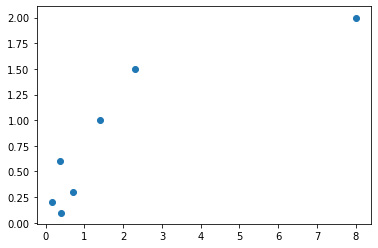

In [31]:
plt.scatter(df['DP[atm]'],df['q[ml/s]'])

### Part 2